# **Configuração Geral**

## Imports

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from fractions import Fraction
import joblib
import scipy.stats as stats
from sklearn.metrics import r2_score

# Machine Learning Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV

## Funções

In [66]:
# Converte uma string que representa polegadas para um float
def polegadas(value):

    # Divide a string recebida
    value = value.strip()

    # Se a string tem mais de uma parte, obtém a parte inteira e calcula a parte decimal
    if ' ' in value:
        inteiro, decimal = value.split(' ') # a parte inteira é o que está antes do ' ', a parte decimal é o que está depois
        polegadas = float(inteiro) + float(Fraction(decimal))

    else:
        polegadas = float(value)
    
    return polegadas

# -------------------------------
# Testa, otimiza e retorna o modelo de melhor performance
def seleciona_modelos(df, model_param_grid):
    # Preparar os dados
    df1 = df.copy()
    df_train = df1[df1['tipo_poco'] != 'DIRECIONAL']
    
    X_train = df_train[['fase', 'lda_lamina_d_agua', 'metragem', 'nfases', 'diametro_fase_polegadas']]
    y_train = df_train['tipo_poco']
    
    # Codificar target
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    
    best_model = None
    best_score = 0
    best_metrics = None
    
    # Iterar sobre os modelos e grids de parâmetros fornecidos
    for model_name, (model, param_grid) in model_param_grid.items():
        print(f"\nTestando {model_name}...")
        
        # Inicializar GridSearchCV
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train_encoded)
        
        # Obter o melhor modelo
        current_best_model = grid_search.best_estimator_
        current_best_score = grid_search.best_score_
        
        # Avaliar o modelo no conjunto de treinamento completo
        y_train_pred_encoded = current_best_model.predict(X_train)
        
        # Imprimir relatórios de avaliação
        # print(f"Modelo: {model_name}")
        # print("Melhores Parâmetros Encontrados:")
        # print(grid_search.best_params_)
        
        # print("Relatório de Classificação (Treinamento):")
        report = classification_report(y_train_encoded, y_train_pred_encoded, target_names=label_encoder.classes_)
        # print(report)
        
        # print("Acurácia no Conjunto de Treinamento:")
        accuracy = accuracy_score(y_train_encoded, y_train_pred_encoded)
        # print(f"{accuracy:.4f}")
        
        # Verificar se é o melhor modelo até agora
        if current_best_score > best_score:
            best_score = current_best_score
            best_model = current_best_model
            best_metrics = {
                'model_name': model_name,
                'best_params': grid_search.best_params_,
                'classification_report': report,
                'accuracy': accuracy
            }
    
    # Imprimir as métricas do melhor modelo dentre todos os testados
    print("\nMelhor Modelo:")
    print(f"Modelo: {best_metrics['model_name']}")
    print("Melhores Parâmetros Encontrados:")
    print(best_metrics['best_params'])
    
    print("Relatório de Classificação (Treinamento):")
    print(best_metrics['classification_report'])
    
    print("Acurácia no Conjunto de Treinamento:")
    print(f"{best_metrics['accuracy']:.4f}")
    
    return best_model
# -------------------------------

# Função para salvar a grid de gráficos
def save_grid_plot(filename):
    plt.savefig(f'img/{filename}')
    # plt.close()
# -------------------------------

# Função para gerar e salvar gráficos de distribuição em uma grid
def plot_distributions_grid(df, columns):
    num_vars = len(columns)
    fig, axes = plt.subplots(nrows=(num_vars + 2) // 3, ncols=3, figsize=(18, 4 * ((num_vars + 2) // 3)))
    axes = axes.flatten()
    
    for i, column in enumerate(columns):
        sns.histplot(df[column], kde=True, ax=axes[i])
        axes[i].set_title(f'Distribuição de {column}')
    
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')  # Desliga os eixos restantes
    
    plt.tight_layout()
    save_grid_plot('distributions_grid.png')
    plt.show() # precisa vir por último, senão nenhum gráfico é exibido no notebook
# -------------------------------

# Função para gerar gráficos boxplots para ajudar a identificar outliers
def detect_outliers(df, numeric_columns):
    """
    Detecta outliers nas variáveis numéricas e salva gráficos boxplot em uma grid.
    
    Parameters:
    df (pd.DataFrame): DataFrame contendo os dados.
    numeric_columns (list): Lista de nomes das colunas numéricas para análise.
    """
    # Criar uma grid de gráficos
    n = len(numeric_columns)
    fig, axes = plt.subplots(nrows=1, ncols=n, figsize=(20, 5))

    for ax, col in zip(axes, numeric_columns):
        sns.boxplot(x=df[col], ax=ax)
        ax.set_title(f'Boxplot de {col}')

    # Ajustar layout e salvar a imagem
    plt.tight_layout()
    save_grid_plot('outliers_boxplots.png')
    plt.show()
# -------------------------------

# Função para contar frequências e visualizar distribuição de valores
def dist_non_numeric(df, non_numeric_features):
    for feature in non_numeric_features:
        # Contar frequências
        freq_counts = df[feature].value_counts()
        print(f"\nContagem de Frequências para {feature}:")
        print(freq_counts)
        
        # Visualizar distribuição de valores
        plt.figure(figsize=(8, 4))
        sns.countplot(data=df, x=feature)
        plt.title(f'Distribuição de {feature}')
        save_grid_plot(f'{feature}_distribution.png')
        plt.show()
# -------------------------------

# Função para plotar o gráfico da análise bivariada por tipo_poco
def bivariada_tipo_poco(df):
    # Criar a grid de gráficos
    fig, axes = plt.subplots(2, 2, figsize=(13, 8))

    # Gráfico boxplot para 'lda_lamina_d_agua' por 'tipo_poco'
    sns.boxplot(x='tipo_poco', y='lda_lamina_d_agua', data=df, ax=axes[0, 0])
    axes[0, 0].set_title('LDA Lamina d\'Agua por Tipo de Poço')

    # Gráfico boxplot para 'metragem' por 'tipo_poco'
    sns.boxplot(x='tipo_poco', y='metragem', data=df, ax=axes[0, 1])
    axes[0, 1].set_title('Metragem por Tipo de Poço')

    # Histograma para contar fases por tipo_poco
    for tipo, ax in zip(['HORIZONTAL', 'VERTICAL'], [axes[1, 0], axes[1, 1]]):
        subset = df[df['tipo_poco'] == tipo]
        sns.histplot(subset, x='fase', bins=4, ax=ax, kde=False)
        ax.set_title(f'Contagem de Fases - {tipo}')

    # Ajustar layout
    plt.tight_layout()

    # Salvar imagem
    save_grid_plot('bivariada_tipo_poco.png')

    #Exibe a imagem
    plt.show()
# -------------------------------

# Função que gera gráficos para análise bivariada por 'fase'
def bivariada_fases(df):
    # Criar a grid de gráficos
    fig, axes = plt.subplots(2, 2, figsize=(13, 8))

    # Gráfico boxplot para 'lda_lamina_d_agua' por 'fase'
    sns.boxplot(x='fase', y='lda_lamina_d_agua', data=df, ax=axes[0, 0])
    axes[0, 0].set_title('LDA Lamina d\'Agua por Fase')

    # Gráfico boxplot para 'metragem' por 'fase'
    sns.boxplot(x='fase', y='metragem', data=df, ax=axes[0, 1])
    axes[0, 1].set_title('Metragem por Fase')

    # Gráfico boxplot para 'diametro_fase_polegadas' por 'fase'
    sns.boxplot(x='fase', y='diametro_fase_polegadas', data=df, ax=axes[1, 0])
    axes[1, 0].set_title('Diâmetro por Fase')

    # Histograma para contagem de fases
    sns.histplot(df, x='fase', bins=4, ax=axes[1, 1], kde=False)
    axes[1, 1].set_title('Contagem de Poços por Fase')

    # Ajustar layout
    plt.tight_layout()

    # Salvar imagem
    save_grid_plot('bivariada_fases.png')

    # Mostrar imagem
    plt.show()
# -------------------------------

# Função para calcular e exibir R2
def plot_with_regression(x, y, data, ax, title):
    sns.regplot(x=x, y=y, data=data, ax=ax)
    ax.set_title(title)
    r2 = r2_score(data[x], data[y])
    ax.annotate(f'R² = {r2:.2f}', xy=(0.05, 0.9), xycoords='axes fraction', fontsize=12, color='red')


# **Carregando Dados**

In [29]:
# Carregando dados csv
df = pd.read_csv('data/dados_pocos.csv')
df.head()

,Unnamed: 0,Nome do Poço,Fase,Tipo Poço,LDA (Lâmina D'Água),Diâmetro Fase,Metragem,NFases
0,0,6C5G4M,1,VERTICAL,598.0,26,607.0,4
1,1,6C5G4M,2,VERTICAL,598.0,17 1/2,1306.0,4
2,2,6C5G4M,3,VERTICAL,598.0,12 1/4,1201.0,4
3,3,6C5G4M,4,VERTICAL,598.0,8 1/2,1445.0,4
4,4,8030JC,1,VERTICAL,0.0,17 1/2,410.0,3


**Características de um poço:**

- **Nome**: Nome que identifica o projeto do poço
- **Fase**: É o número da fase. Um projeto é dividido em fases.
- **Tipo Poço**: Existem aqui 2 tipos de poços VERTICAL ou HORIZONTAL.
- **LDA (Lâmina D'Água)**: LDA é o valor em metros, que corresponde a distância entre a superfície do mar até o ponto de perfuração em poços  subaquáticos.
- **Diâmetro Fase**: Para cada fase da perfuração pode-se usar uma broca com diâmetro diferente. Aqui o diâmetro é descrito em polegadas.
- **Metragem**: Valor em metros que corresponde ao total perfurado naquela fase.
- **N_Fases**: Corresponde ao número total de fases que o projeto exigiu.

# **Limpeza dos Dados**
- Tratamento de valores ausentes
- Remoção de outliers
- Correção de tipos de dados

In [30]:
# Renomear as colunas para o padrão PEP8
df.columns = ['index', 'nome_do_poco', 'fase', 'tipo_poco', 'lda_lamina_d_agua', 'diametro_fase', 'metragem', 'nfases']

# Remover a coluna de índices 'Unnamed: 0'
df = df.drop(columns=['index'])

# Exibir df
df.head()

,nome_do_poco,fase,tipo_poco,lda_lamina_d_agua,diametro_fase,metragem,nfases
0,6C5G4M,1,VERTICAL,598.0,26,607.0,4
1,6C5G4M,2,VERTICAL,598.0,17 1/2,1306.0,4
2,6C5G4M,3,VERTICAL,598.0,12 1/4,1201.0,4
3,6C5G4M,4,VERTICAL,598.0,8 1/2,1445.0,4
4,8030JC,1,VERTICAL,0.0,17 1/2,410.0,3


In [31]:
# Verificar tipos de cada coluna
print(df.dtypes)

nome_do_poco          object
fase                   int64
tipo_poco             object
lda_lamina_d_agua    float64
diametro_fase         object
metragem             float64
nfases                 int64
dtype: object


In [32]:
# Verificar quantidade de valores ausentes por coluna
missing_values = df.isna().sum()
missing_values_percentage = (missing_values / len(df)) * 100
missing_values_df = pd.DataFrame({'valores_nulos': missing_values, 'percentual': missing_values_percentage})
print(missing_values_df)

                   valores_nulos  percentual
nome_do_poco                   0         0.0
fase                           0         0.0
tipo_poco                      0         0.0
lda_lamina_d_agua              0         0.0
diametro_fase                  0         0.0
metragem                       0         0.0
nfases                         0         0.0


In [33]:
# Verificar quantidade de linhas duplicadas
duplicate_count = df.duplicated().sum()
print(f'Quantidade de linhas duplicadas: {duplicate_count}')

Quantidade de linhas duplicadas: 0


In [34]:
# Converte coluna de string para float
df['diametro_fase_polegadas'] = df['diametro_fase'].apply(polegadas)
df.drop(columns='diametro_fase', inplace=True)
df.dtypes

nome_do_poco                object
fase                         int64
tipo_poco                   object
lda_lamina_d_agua          float64
metragem                   float64
nfases                       int64
diametro_fase_polegadas    float64
dtype: object

## Corrigindo a coluna 'tipo_poco'
- O exercício informa que existem apenas 02 tipos: VERTICAL e HORIZONTAL
- Mas o dataset tem mais valores além desses: DIRECIONAL e '0'
- data imputting

In [35]:
df['tipo_poco'].unique()

array(['VERTICAL', 'DIRECIONAL', '0', 'HORIZONTAL'], dtype=object)

Diante da quantidade de valores incorretos, tenho que pensar numa abordagem cautelosa para substituir esses valores.

In [36]:
# Contando quantas linhas têm valores incorretos para 'tipo_poco'
counts = df['tipo_poco'].value_counts()
direcional_count = counts.get('DIRECIONAL', 0)
zero_count = counts.get('0', 0)

# Calcular a porcentagem
total_count = len(df['tipo_poco'])
direcional_perc = (direcional_count / total_count) * 100
zero_perc = (zero_count / total_count) * 100

print(f"Porcentagem de valores com DIRECIONAL: {direcional_perc:.2f}%")
print(f"Porcentagem de valores com 0: {zero_perc:.2f}%")

Porcentagem de valores com DIRECIONAL: 35.80%
Porcentagem de valores com 0: 1.42%


### Imputação de dados com Machine Learning
- Vou utilizar um modelo de Machine Learning para prever (**classificar**) o valor correto de 'tipo_poco' com base nas características das ocorrências corretas do dataset. 
- Esse modelo será aplicado às ocorrências com 'tipo_poco' = 'DIRECIONAL'
- **Por que escolhi essa abordagem?** Para preservar ao máximo as características do dataset após a imputação de dados. Usar um método mais simples (como a moda) sobre uma grande quantidade de ocorrências (~36%) poderia induzir os modelos de ML ao erro durante a fase de modelagem, pois ele poderia encontrar características de um poço HORIZONTAL junto com o 'tipo_poco' VERTICAL, por exemplo.

In [37]:
# Primeiro eu vou tratar as ocorrências com zero: vou remover todas as linhas com valores '0', já que são poucas (1.4%)
df = df[df['tipo_poco'] != '0']

In [44]:
# Definir os modelos e seus respectivos grids de parâmetros
model_param_grid = {
    'RandomForest': (RandomForestClassifier(), {
        'n_estimators': [50, 100, 150],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }),
    'KNN': (KNeighborsClassifier(), {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan', 'minkowski']
    }),
    'DecisionTree': (DecisionTreeClassifier(), {
        'criterion': ['gini', 'entropy'],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    })
}

# Testar os modelos e obter o melhor
best_model = seleciona_modelos(df, model_param_grid)


Testando RandomForest...



Testando KNN...

Testando DecisionTree...

Melhor Modelo:
Modelo: RandomForest
Melhores Parâmetros Encontrados:
{'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 50}
Relatório de Classificação (Treinamento):
              precision    recall  f1-score   support

  HORIZONTAL       0.96      0.81      0.88      1715
    VERTICAL       0.94      0.99      0.96      4971

    accuracy                           0.94      6686
   macro avg       0.95      0.90      0.92      6686
weighted avg       0.94      0.94      0.94      6686

Acurácia no Conjunto de Treinamento:
0.9429


In [46]:
# Gravar melhor modelo de imputação
joblib.dump(best_model, 'models/best_model.pkl')

['models/best_model.pkl']

In [58]:
# Imputar os dados corretos em 'tipo_poco' utilizando o melhor modelo de imputação

# Carregar o melhor modelo encontrado
best_model = joblib.load('models/best_model.pkl')

# Preparar os dados para previsão
df_direcional = df[df['tipo_poco'] == 'DIRECIONAL'] # monta um df apenas com as ocorrências de 'DIRECIONAL'
X_direcional = df_direcional[['fase', 'lda_lamina_d_agua', 'metragem', 'nfases', 'diametro_fase_polegadas']]

# Codificar o target apenas com os rótulos de 'HORIZONTAL' e 'VERTICAL'
label_encoder = LabelEncoder()
label_encoder.fit(['HORIZONTAL', 'VERTICAL'])  # Ajustar encoder com rótulos do modelo --> modelo foi treinado para retornar '0' e '1' apenas (HORIZONTAL e VERTICAL, não nessa ordem)

# Realizar previsões
y_pred_encoded = best_model.predict(X_direcional)

# Converter previsões de volta para os rótulos originais
y_pred = label_encoder.inverse_transform(y_pred_encoded)

# Substituir valores 'DIRECIONAL' com previsões
df.loc[df['tipo_poco'] == 'DIRECIONAL', 'tipo_poco'] = y_pred

In [65]:
# Gravar dataframe limpo
df.to_csv('data/df_cleaned.csv', index=False)
print('Dataframe limpo gravado com sucesso!')

Dataframe limpo gravado com sucesso!


# **Análise Exploratória de Dados (EDA)**
- Extrair insights de negócio
- Estatísticas descritivas
- Distribuições de variáveis
- Análise de correlação
- Visualizações (histogramas, scatter plots, heatmaps, etc.)

In [4]:
# Carregando dataset limpo
df = pd.read_csv('data/df_cleaned.csv')
df.head()

,nome_do_poco,fase,tipo_poco,lda_lamina_d_agua,metragem,nfases,diametro_fase_polegadas
0,6C5G4M,1,VERTICAL,598.0,607.0,4,26.00
1,6C5G4M,2,VERTICAL,598.0,1306.0,4,17.50
2,6C5G4M,3,VERTICAL,598.0,1201.0,4,12.25
3,6C5G4M,4,VERTICAL,598.0,1445.0,4,8.50
4,8030JC,1,VERTICAL,0.0,410.0,3,17.50


## Estatísticas Descritivas

In [70]:
# Informações gerais do dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10498 entries, 0 to 10497
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   nome_do_poco             10498 non-null  object 
 1   fase                     10498 non-null  int64  
 2   tipo_poco                10498 non-null  object 
 3   lda_lamina_d_agua        10498 non-null  float64
 4   metragem                 10498 non-null  float64
 5   nfases                   10498 non-null  int64  
 6   diametro_fase_polegadas  10498 non-null  float64
dtypes: float64(3), int64(2), object(2)
memory usage: 574.2+ KB


In [71]:
# Estatística descritiva (apenas das colunas numéricas)
df.describe().round(2)

,fase,lda_lamina_d_agua,metragem,nfases,diametro_fase_polegadas
count,10498.00,10498.00,10498.00,10498.00,10498.00
mean,2.67,1115.23,680.76,4.27,16.80
std,1.54,729.06,563.40,1.81,8.54
min,1.00,0.00,0.00,1.00,0.00
25%,1.00,466.75,188.25,3.00,9.50
50%,2.00,1098.00,609.00,4.00,12.25
75%,4.00,1735.00,1027.00,5.00,22.00
max,8.00,2988.00,4040.00,9.00,42.00


## Análise univariada
- Compreender distribuição
- Procurar outliers

### Análise Univariada - Dados Numéricos

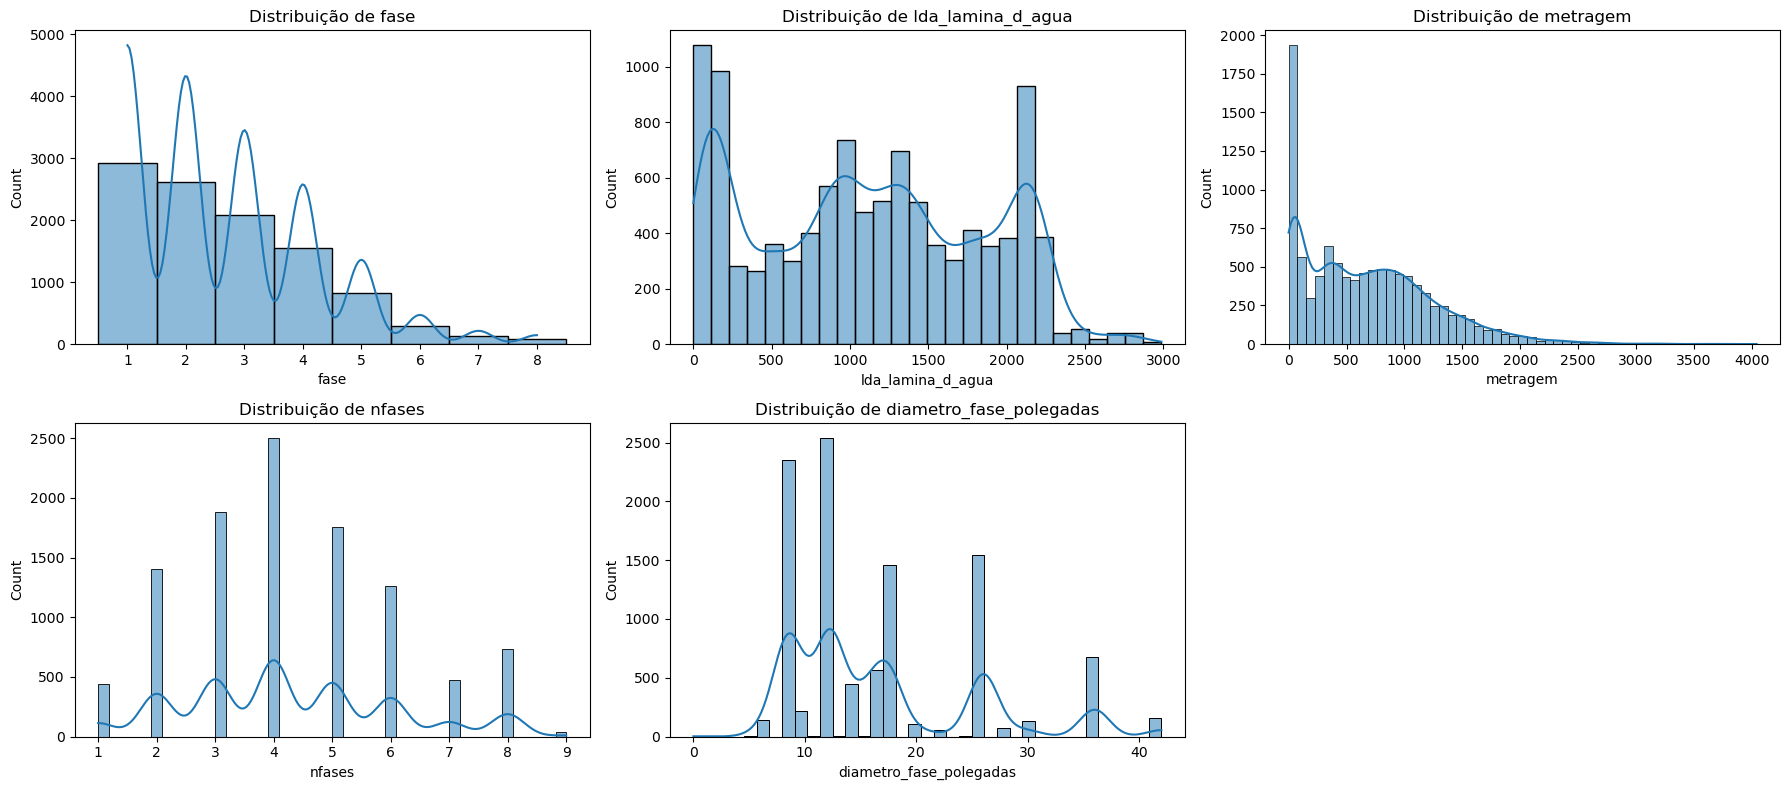

In [32]:
# Analisar a distribuição de variáveis numéricas
numeric_columns = ['fase', 'lda_lamina_d_agua', 'metragem', 'nfases', 'diametro_fase_polegadas']
plot_distributions_grid(df, numeric_columns)

Procurando outliers:

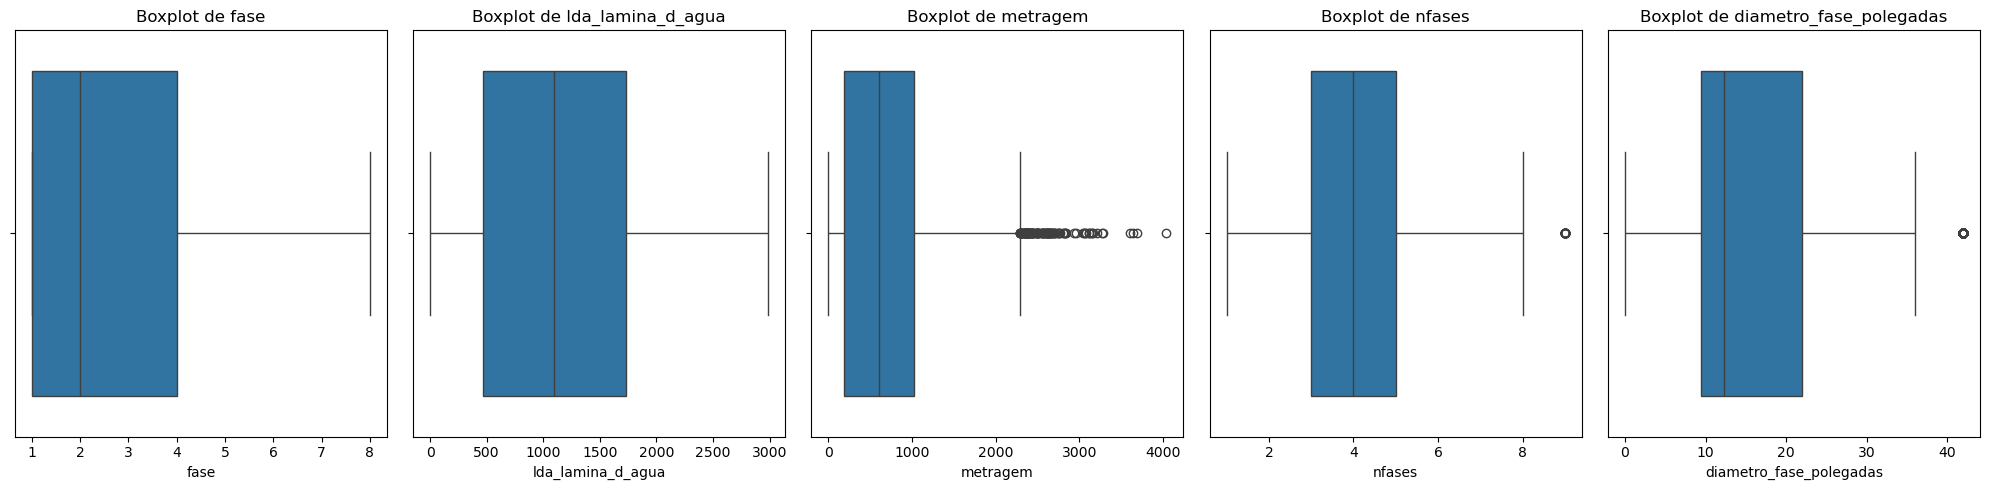

In [33]:
# Procurando outliers
detect_outliers(df, ['fase', 'lda_lamina_d_agua', 'metragem', 'nfases', 'diametro_fase_polegadas'])

### Análise Univariada - Dados Não-Numéricos


Contagem de Frequências para tipo_poco:
tipo_poco
HORIZONTAL    5527
VERTICAL      4971
Name: count, dtype: int64


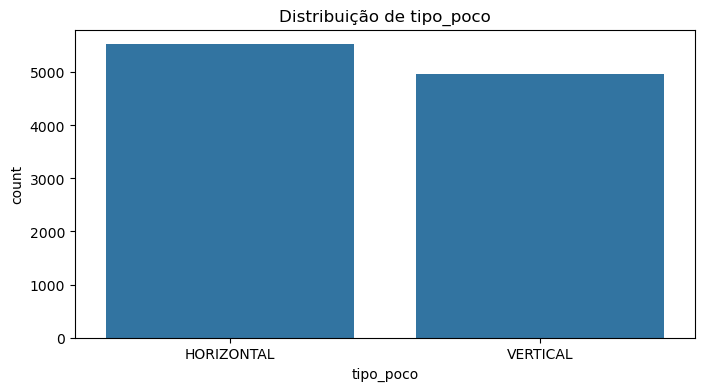

In [34]:
# Distribuição de tipos de poço
dist_non_numeric(df, ['tipo_poco'])

## Análise Bivariada
- relação entre 'tipo_poco' e features numéricas:
    - média, mediana, desvio padrão, contagem (usar 'describe')
    - gráficos
- relação entre 'fase' e features numéricas
- relação entre features numéricas
    - gráficos de dispersão com linha de regressão linear exibindo o r2
- correlação entre features
    - codificar as categorias para números
    - calcular a matriz de correlação (heatmap)

In [35]:
# 'fase' é, na verdade, uma categoria
# Converter 'fase' e 'tipo_poco' para categóricos
df['fase'] = df['fase'].astype('category')
df['tipo_poco'] = df['tipo_poco'].astype('category')

In [45]:
# Analisando apenas colunas numéricas
numeric_columns = df.select_dtypes(include='number').columns

### Relação entre 'tipo_poco' e as features numéricas

In [37]:
import pandas as pd

# Agrupar por 'tipo_poco' e descrever as variáveis numéricas
grouped_df = df.groupby('tipo_poco').describe(include='number').round(2)

# Transpor o DataFrame para que as colunas representem os tipos de 'tipo_poco'
transposed_df = grouped_df.T

transposed_df

/tmp/ipykernel_845/2218035633.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_df = df.groupby('tipo_poco').describe(include='number').round(2)


tipo_poco                      HORIZONTAL  VERTICAL
lda_lamina_d_agua       count     5527.00   4971.00
                        mean      1020.27   1220.82
                        std        652.93    792.11
                        min          0.00      0.00
                        25%        457.00    474.00
                        50%        988.00   1275.00
                        75%       1467.00   1967.00
                        max       2673.00   2988.00
metragem                count     5527.00   4971.00
                        mean       698.03    661.56
                        std        534.48    593.38
                        min          0.00      0.00
                        25%        266.50     86.00
                        50%        653.00    550.00
                        75%       1035.00   1019.00
                        max       4040.00   3683.00
nfases                  count     5527.00   4971.00
                        mean         3.74      4.86
                        std          1.65      1.80
                        min          1.00      1.00
                        25%          2.00      4.00
                        50%          4.00      5.00
                        75%          5.00      6.00
                        max          9.00      9.00
diametro_fase_polegadas count     5527.00   4971.00
                        mean        16.15     17.53
                        std          8.10      8.96
                        min          0.00      0.00
                        25%          9.50     12.25
                        50%         12.25     14.75
                        75%         17.50     26.00
                        max         42.00     42.00

- Distribuição de valores de metragem, lâmina dágua por tipo de poço;
- Contagem de fases por tipo de poço.

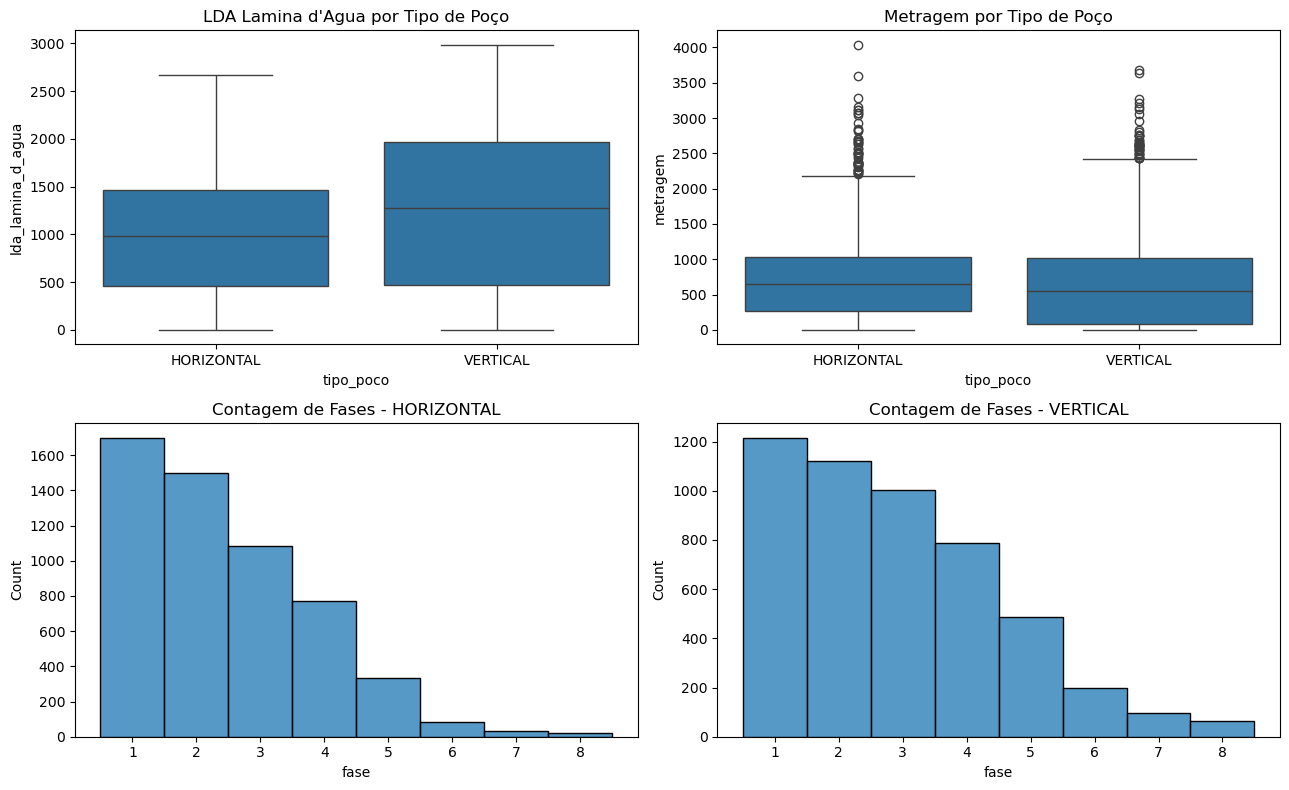

In [44]:
bivariada_tipo_poco(df)

### Relação entre 'fases' e as features numéricas

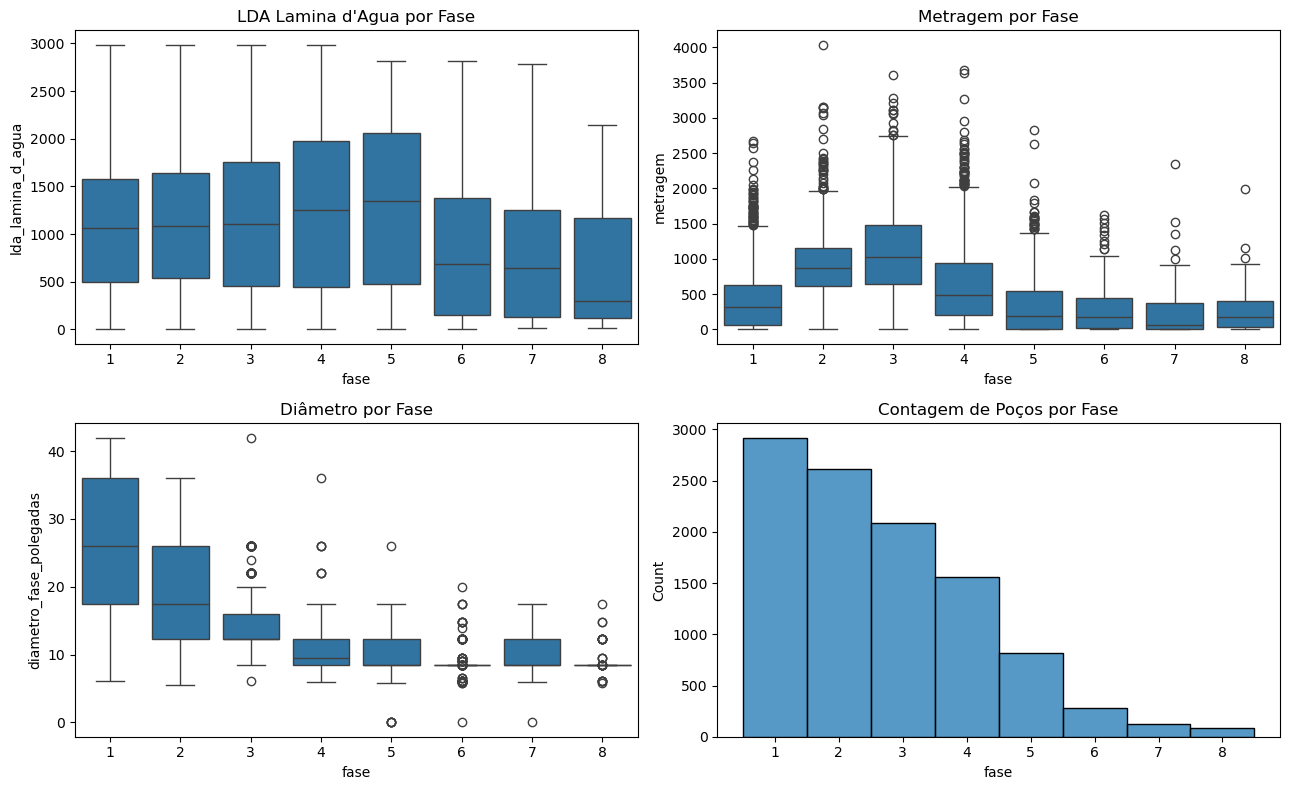

In [55]:
bivariada_fases(df)

### Relações entre features numéricas
Não foi observada relação visível entre as features numéricas. Foi necessário agrupoar por 'fase' para visualizar algum tipo de relação.

In [56]:
numeric_columns

Index(['lda_lamina_d_agua', 'metragem', 'nfases', 'diametro_fase_polegadas'], dtype='object')

Perceba como cada poço pode ter várias fases. Isso dificulta a análise de relações entre as features numéricas.

No caso do poço '7NTY69', observe que a cada fase apenas a metragem do poço foi aumentando. É a profundidade da perfuração em solo (abaixo do mar). A profundidade do início do poço, no fundo do mar, é medida pela lda.

**A metragem é o valor perfurado naquela fase.**

Os gráficos não são informativos porque estão observando um pedaço da 'série temporal' que são as fases de cada poço. Para enxergar a tendência é preciso considerar esse aspecto.

**Logo, será necessário transformar o dataset para estudar as relações entre as features numéricas.**

- fases = data da observação
- nfases = idade do poço
- agrupar por nome_do_poco. Somar a metragem de cada fase para obter a metragem final de cada poço.
- estudar tipo_poco e fase. Agrupar. Fazer um describe.

In [75]:
df2 = df.copy()

# Supondo que df seja seu DataFrame
#df2['distancia_perfurada'] = df2.groupby('nome_do_poco')['metragem'].transform('sum')

# Supondo que df seja seu DataFrame
df2['distancia_perfurada_cumulativa'] = df2.groupby('nome_do_poco')['metragem'].cumsum()

df2[df2['nome_do_poco']=='GX9SUN']

,nome_do_poco,fase,tipo_poco,lda_lamina_d_agua,metragem,nfases,diametro_fase_polegadas,distancia_perfurada_cumulativa
6724,GX9SUN,1,HORIZONTAL,108.0,310.0,8,26.00,310.0
6725,GX9SUN,2,HORIZONTAL,108.0,0.0,8,17.50,310.0
6726,GX9SUN,3,HORIZONTAL,108.0,0.0,8,12.25,310.0
6727,GX9SUN,4,HORIZONTAL,108.0,0.0,8,17.50,310.0
6728,GX9SUN,5,HORIZONTAL,108.0,0.0,8,12.25,310.0
6729,GX9SUN,6,HORIZONTAL,108.0,53.0,8,17.50,363.0
6730,GX9SUN,7,HORIZONTAL,108.0,2344.0,8,12.25,2707.0
6731,GX9SUN,8,HORIZONTAL,108.0,269.0,8,8.50,2976.0


Agrupando por fase:

/tmp/ipykernel_845/3904219303.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_agg_phase = df.groupby('fase').agg({


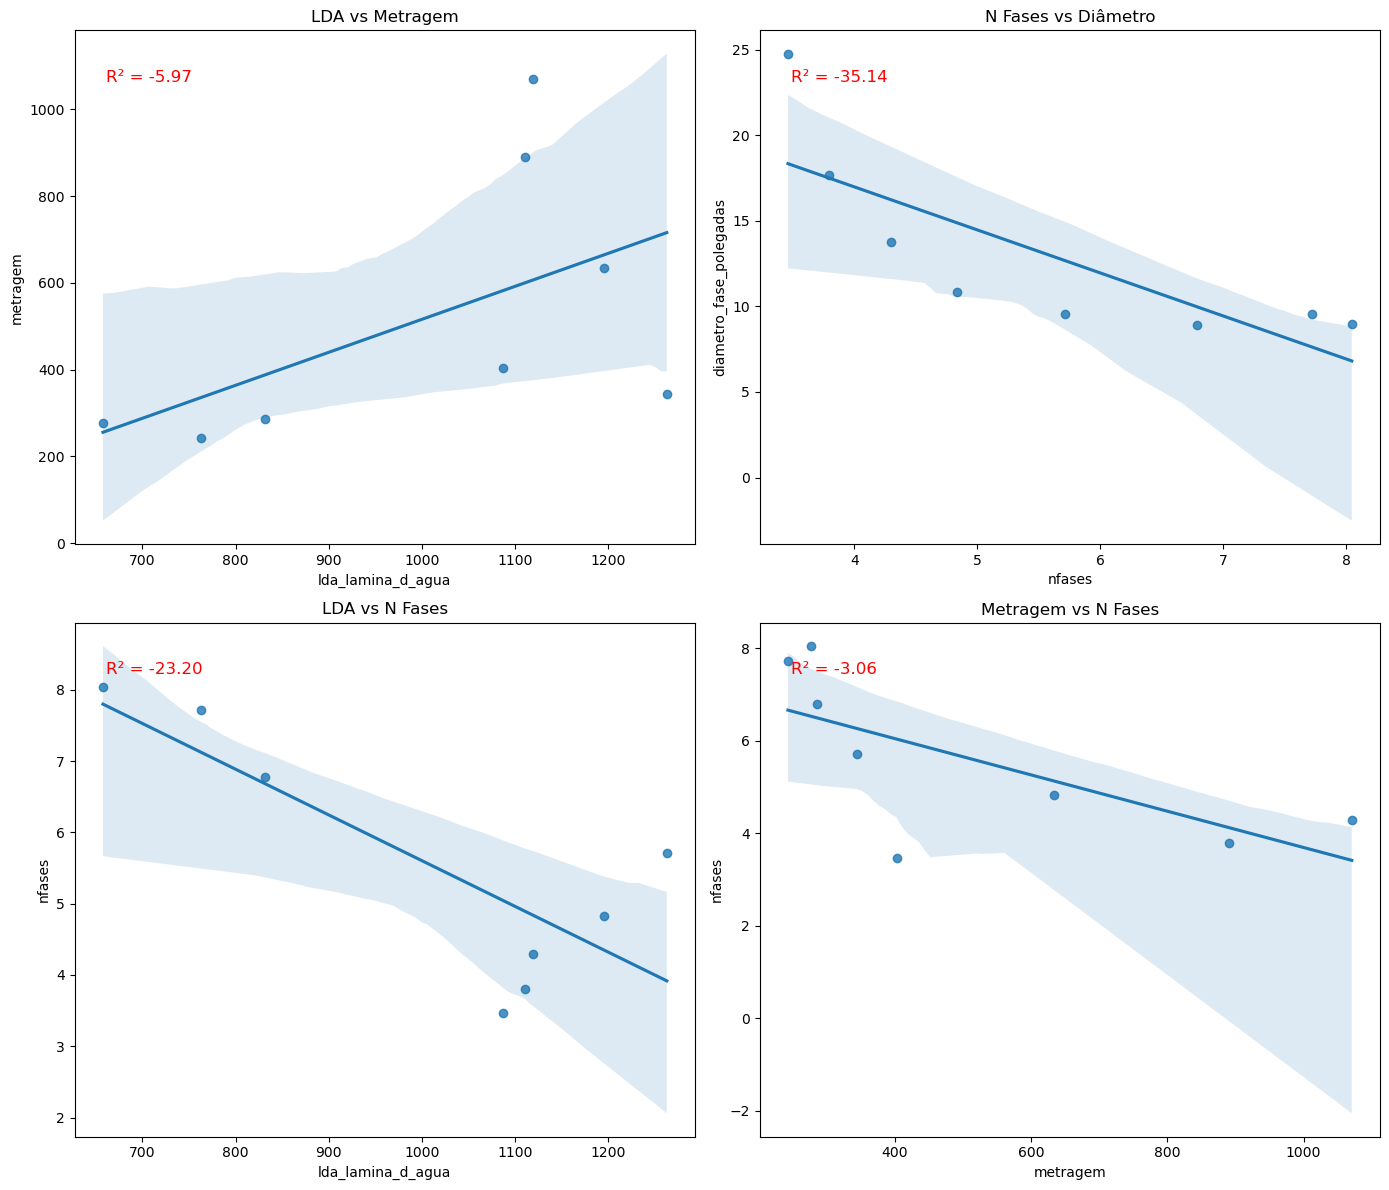

In [64]:
df_agg_phase = df.groupby('fase').agg({
    'lda_lamina_d_agua': 'mean',
    'metragem': 'mean',
    'nfases': 'mean',
    'diametro_fase_polegadas': 'mean'
}).reset_index()

# Criar a grid de gráficos
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# lda_lamina_d_agua vs metragem
plot_with_regression('lda_lamina_d_agua', 'metragem', df_agg_phase, axes[0, 0], 'LDA vs Metragem')

# nfases vs diametro_fase_polegadas
plot_with_regression('nfases', 'diametro_fase_polegadas', df_agg_phase, axes[0, 1], 'N Fases vs Diâmetro')

# lda_lamina_d_agua vs nfases
plot_with_regression('lda_lamina_d_agua', 'nfases', df_agg_phase, axes[1, 0], 'LDA vs N Fases')

# metragem vs nfases
plot_with_regression('metragem', 'nfases', df_agg_phase, axes[1, 1], 'Metragem vs N Fases')

# Ajustar layout
plt.tight_layout()

# Mostrar imagem
plt.show()


# **Feature Engineering**
- Criação de novas variáveis
- Seleção de variáveis
- Transformações de variáveis
- Codificação de variáveis categóricas

# **Pré-processamento dos Dados**
- Divisão dos dados em treino e teste
- Escalonamento de características
- Preparação de dados para modelagem

# **Modelagem** (Machine Learning)
- Escolha dos modelos
- Treinamento dos modelos
- Avaliação de desempenho dos modelos
- Ajuste de hiperparâmetros

# **Avaliação do Modelo**
- Métricas de avaliação (precision, recall, F1-score, etc.)
- Curvas ROC e AUC
- Análise de erros

# **Deploy do Modelo**
- Gravação do modelo treinado
- Carregamento do modelo para previsões futuras

# **Conclusões**
- Sumário dos resultados
- Recomendações
- Próximos passos

# **Referências**
- Citações e referências utilizadas